In [7]:
# May cause deprecation warnings, safe to ignore, they aren't errors

from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

# Can only run this once. restart your kernel for any errors.
conf = SparkConf().setMaster("local").setAppName("streaming")
sc = SparkContext.getOrCreate(conf=conf) 

ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)
socket_stream = ssc.socketTextStream("127.0.0.1", 5554)
lines = socket_stream.window( 20 )
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

In [9]:
!pip install "tweepy==3.7"

  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.4.0
    Uninstalling tweepy-4.4.0:
      Successfully uninstalled tweepy-4.4.0


In [10]:
ssc.start()    

In [11]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

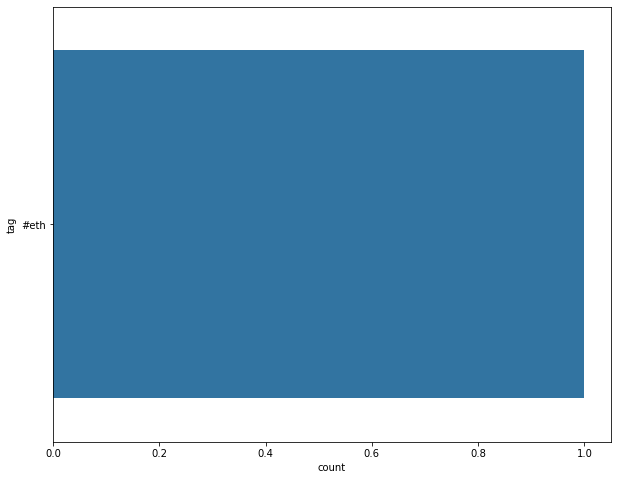

In [13]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
#     sns.barplot(x='count',y='land_cover_specific', data=df, palette='Spectral')
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [16]:
ssc.stop()